In [55]:
import glob 
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from music21 import converter, instrument, note, chord
import time
import pickle


In [56]:
def get_notes():
    
    notes = []
    
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        #print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
        
    return notes


In [57]:
notes = get_notes() 

pitchnames = sorted(set(item for item in notes))

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

vocab_size = len(note_to_int)

seq_len = 100

    
in_seq_0 = []
tar_seq_0 = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - seq_len, 1):
    sequence_in = notes[i:i + seq_len]
    sequence_out = notes[i + seq_len]
    
    for j in range(0, seq_len, 1):
        in_seq_0.append(note_to_int[sequence_in[j]])
        
    tar_seq_0.append(note_to_int[sequence_out])
# save the input- and outputsseq to the file 
with open('notes_in', 'wb') as fp:
    pickle.dump(in_seq_0, fp)
    
with open('notes_tar', 'wb') as fp:
    pickle.dump(tar_seq_0, fp)
    

In [36]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, embedding_dim, batch_size, hidden_dim, output_size):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        
        self.hidden_dim = hidden_dim
        
        self.embeddings = nn.Embedding(input_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.linear = nn.Linear(hidden_dim, output_size)
        

    def init_hidden(self):

        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))
    

    def forward(self, inputs):
        
        hidden = self.init_hidden()
        
        embeds = self.embeddings(inputs)
        
        lstm_out, hidden = self.lstm(embeds.view(len(net_in_tensor), 1, -1), hidden)
        
        prediction = self.linear(lstm_out.view(len(net_in_tensor), -1))
        pre_scores = F.log_softmax(prediction, dim=1)
        return pre_scores 

In [61]:
input_size = vocab_size

embedding_dim = 30
batch_size = 1
hidden_dim = 36
learning_rate = 0.01

model = LSTM(input_size, embedding_dim, batch_size, hidden_dim, vocab_size)

model.zero_grad()
model.hidden = model.init_hidden()

lossfunction = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)


Epochs = 3000

save_every = 100
print_every = 50

In [63]:
start = time.time()
total_Loss = []

for e in range(Epochs):
    
    total_Loss.append(0)
    
    with open ('notes_in', 'rb') as fp:
        in_seq = pickle.load(fp)
    
    with open ('notes_tar', 'rb') as fp:
        tar_seq = pickle.load(fp)
    
    
    counter = 0
    while len(in_seq) != 0:
        
        counter += 1
        
        if (len(in_seq) >= 100 and len(tar_seq) != 0):
            
            optimizer.zero_grad()
            
            net_in = in_seq[:100]
            del in_seq[:100]
            net_in_tensor= torch.tensor(net_in, dtype=torch.long)
            net_out = model(net_in_tensor)
            #get the last list of output array as output1
            net_out1 = torch.narrow(net_out, 0, 99, 1)
            target1 = torch.tensor([tar_seq.pop()], dtype=torch.long)
            
            if (len(in_seq) >= 100 and len(tar_seq) != 0):
                optimizer.zero_grad()
                net_in = in_seq[:100]
                del in_seq[:100]
                net_in_tensor= torch.tensor(net_in, dtype=torch.long)
                net_out = model(net_in_tensor)
                #get the last list of output array as output2
                net_out2 = torch.narrow(net_out, 0, 99, 1)
                target2 = torch.tensor([tar_seq.pop()], dtype=torch.long)
                #change the dimention of the inputs of lossfunction from 1 to 2
                output_seq = torch.cat((net_out1, net_out2), 0)
                target_seq = torch.cat((target1, target2), 0)
                loss = lossfunction(output_seq, target_seq)
            
                loss.backward()
                optimizer.step()

                total_Loss[-1] += loss.item() 
            else:
                break         
        else:
            break
    #save the weights of the Model        
    if e % save_every == 0:
        torch.save(model.state_dict(), f'./net_{e}.pth')
    #print the Loss and Time of the training 
    if e % print_every == 0:   
        print('Epoch {}: Total Loss = {}, Avg. Time/Epoch = {}'
                .format(e, total_Loss[-1], (time.time() - start) / print_every))
        start = time.time()

Epoch 0: Total Loss = 1127.7060945034027, Avg. Time/Epoch = 23.89295792579651
Epoch 1: Total Loss = 850.0507791042328, Avg. Time/Epoch = 23.408787965774536


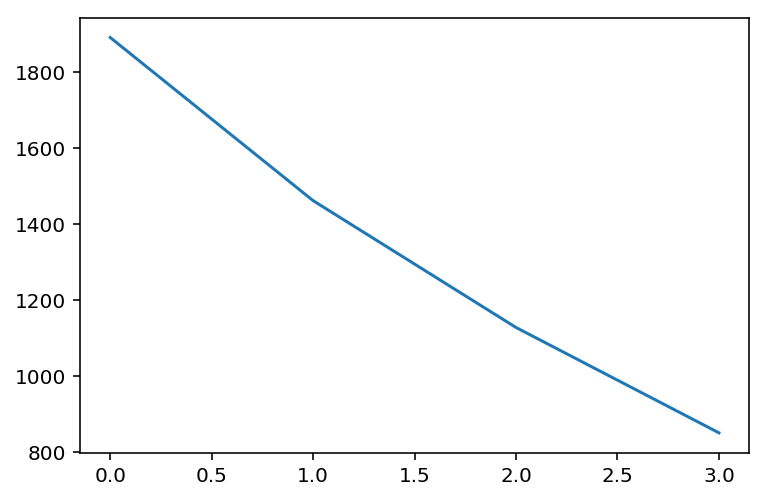

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(total_Loss)